# House price prediction

We use the classic [house price dataset from kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction) to fit a simple linear regression model to predict house price.

This notebook has code for ridge regression, stochastic gradient descent and cross validation coded from scratch.

In [1]:
# import dependancies
import numpy as np
import pandas as pd
import scipy
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings

import matplotlib.pylab as plt
import seaborn as sns;
sns.set_context('poster')
sns.set_style('darkgrid')

In [2]:
warnings.simplefilter("ignore")

# Read in data and drop nans
df = pd.read_csv('kc_house_data.csv')
df.dropna(axis=0, how='any', inplace=True)
# Drop date and zipcode as we will not use them in the analysis
df.drop(labels=['date','zipcode'],axis=1, inplace=True)
# Create development dataset "df" and test dataset "df_test" 
df, df_test = train_test_split(df, test_size=0.1)
df.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

# Create a matrix from the columns of the development dataset
# and scale these columns 
# Apply the same scaling to the test set
cols = [i for i in list(df.columns) if i not in ['id','price']]
x_dev = df.as_matrix(columns=cols)
x_test = df_test.as_matrix(columns=cols)
# Fit scaler only on dev set only
scaler = StandardScaler().fit(x_dev)
df.drop(labels=cols,axis=1,inplace=True)
df_test.drop(labels=cols,axis=1,inplace=True)
for col in cols:
    df[col] = scaler.fit_transform(x_dev[:,cols.index(col)].reshape(-1,1))
    df_test[col] = scaler.fit_transform(x_test[:,cols.index(col)].reshape(-1,1))
    

df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,8847400115,590000.0,-0.396214,-0.147518,0.371153,4.643689,0.012129,-0.088157,-0.305763,-0.629287,0.290713,0.763855,-0.659233,1.159102,-0.209117,-1.402712,1.676135,1.742999,7.238266
1,3423059140,526000.0,0.677599,0.177292,0.969271,0.944630,0.937321,-0.088157,-0.305763,-0.629287,0.290713,1.427459,-0.659233,0.410855,4.787220,-0.916440,0.483667,0.399965,-0.228667
2,9406520550,307500.0,-0.396214,0.177292,-0.470564,-0.184887,0.937321,-0.088157,-0.305763,-0.629287,-0.557952,-0.170017,-0.659233,0.784979,-0.209117,-1.417184,1.257352,-0.016083,-0.130789
3,6661200320,163500.0,-1.470026,-0.797136,-1.118707,-0.279522,0.937321,-0.088157,-0.305763,-0.629287,-0.557952,-0.889123,-0.659233,0.853001,-0.209117,-1.271013,1.243156,-1.366417,-0.339325
4,7202331220,635000.0,2.825223,0.502101,1.958886,-0.224804,0.937321,-0.088157,-0.305763,-0.629287,-0.557952,2.525423,-0.659233,1.091080,-0.209117,0.876688,1.250254,0.925500,-0.279313


In [3]:
df.shape

(19451, 19)

corr between price and bedrooms : 0.304137283097


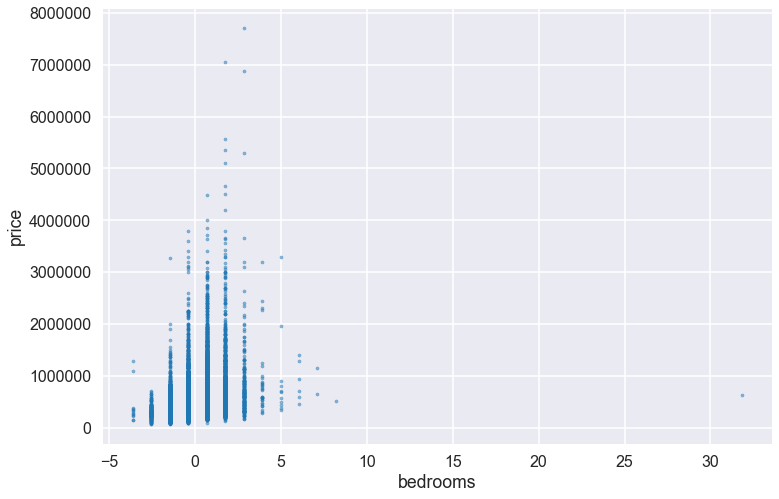

corr between price and bathrooms : 0.525023316406


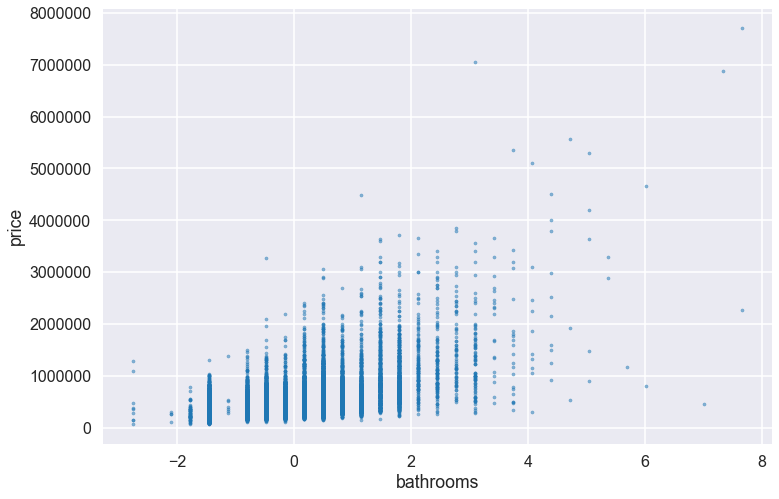

corr between price and sqft_living : 0.704492822853


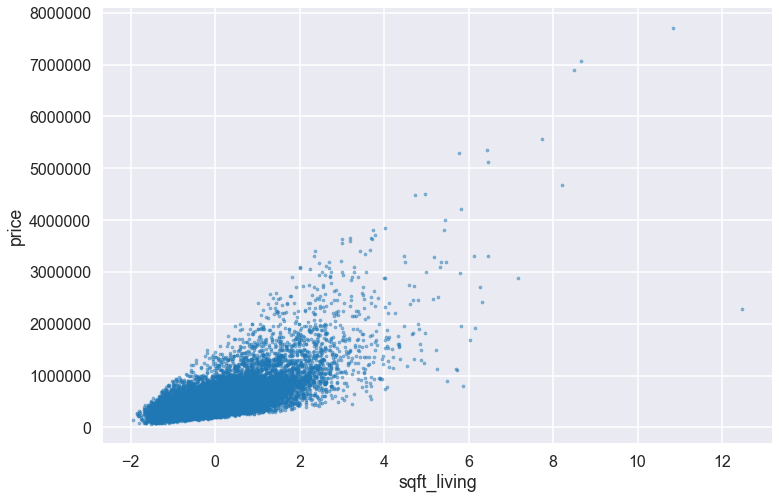

corr between price and sqft_lot : 0.0879589158234


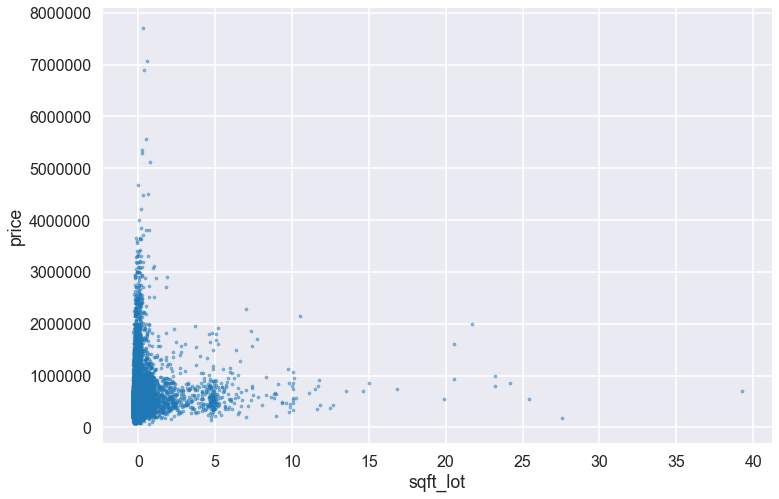

corr between price and floors : 0.256734191578


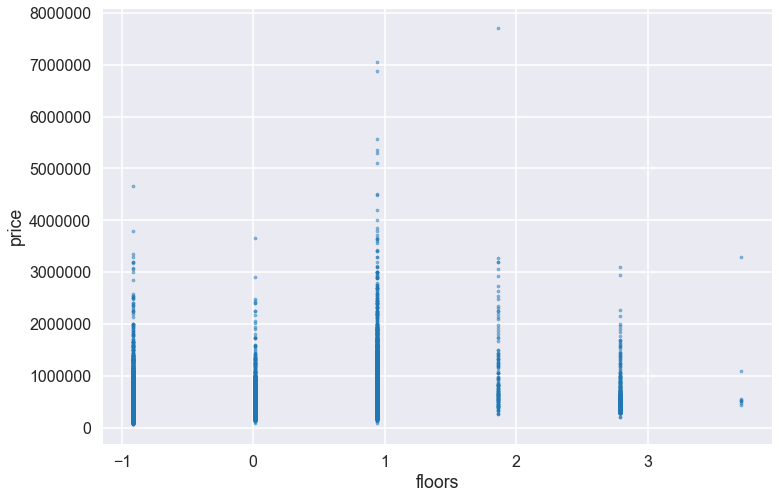

corr between price and waterfront : 0.27209922103


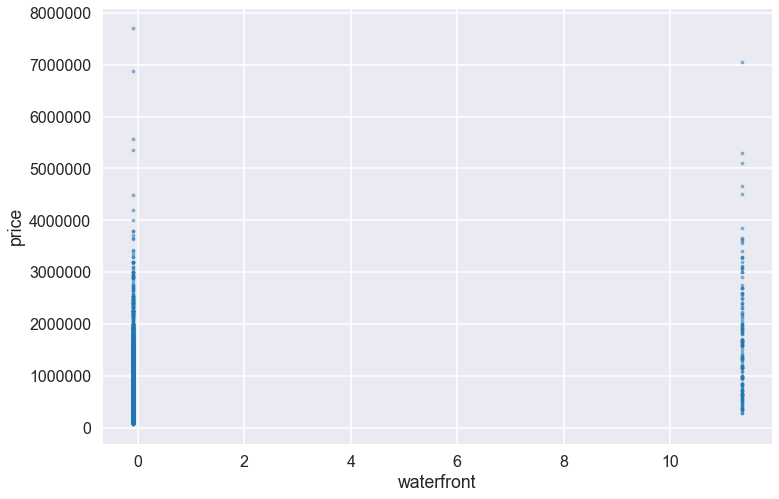

corr between price and view : 0.400094773429


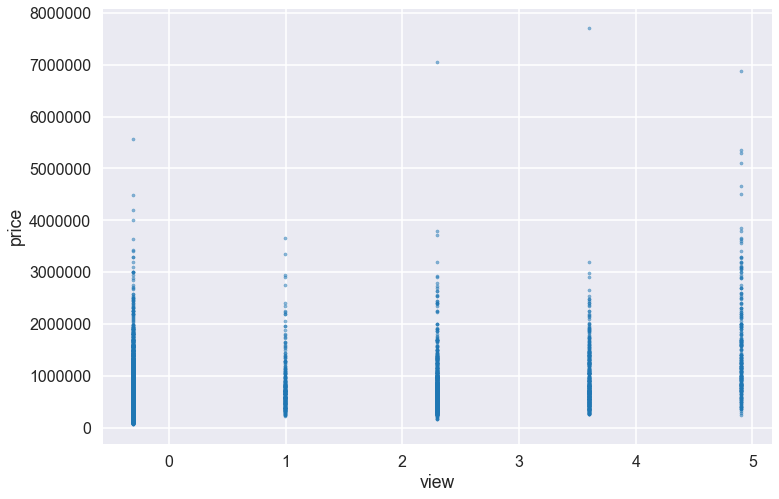

corr between price and condition : 0.0356489502507


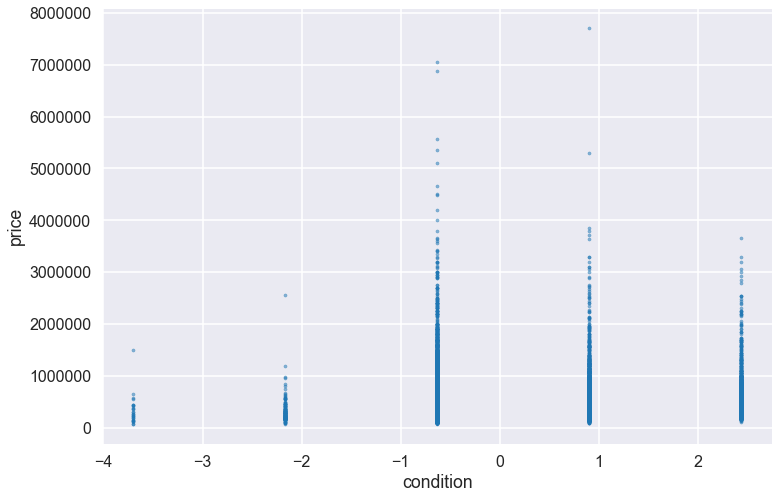

corr between price and grade : 0.667398340742


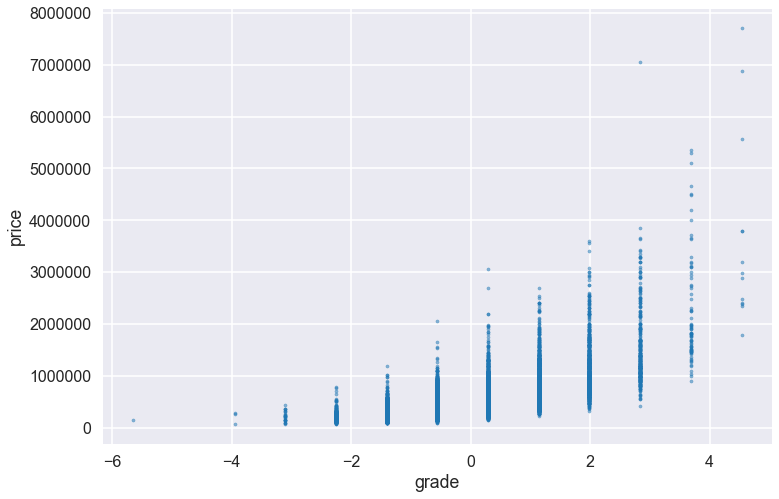

corr between price and sqft_above : 0.607506741644


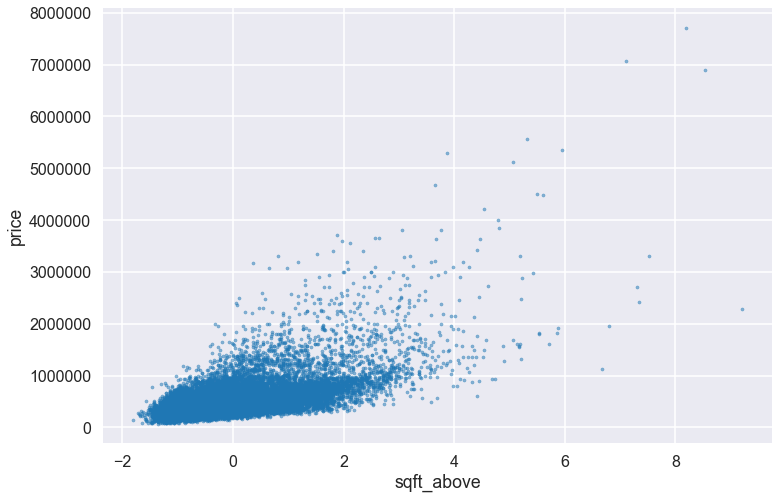

corr between price and sqft_basement : 0.32603031293


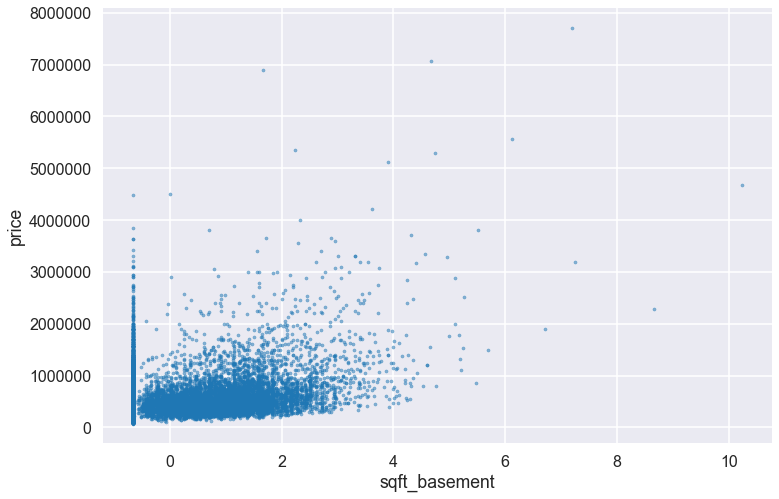

corr between price and yr_built : 0.054401474687


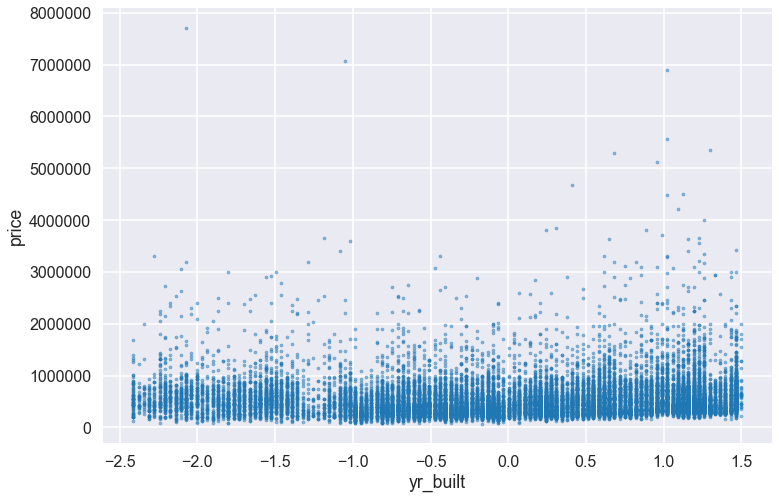

corr between price and yr_renovated : 0.131630054547


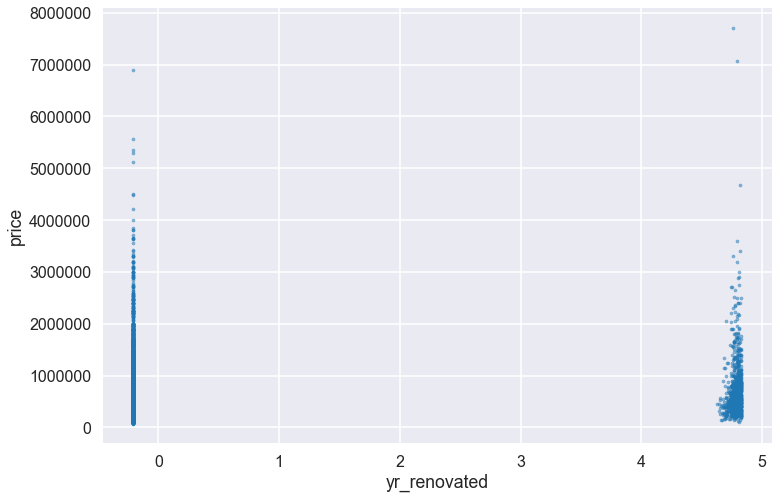

corr between price and lat : 0.304605984097


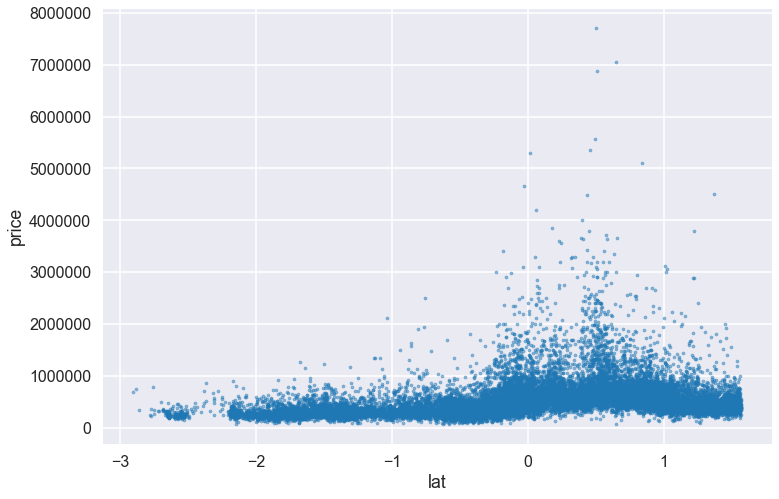

corr between price and long : 0.0205194907266


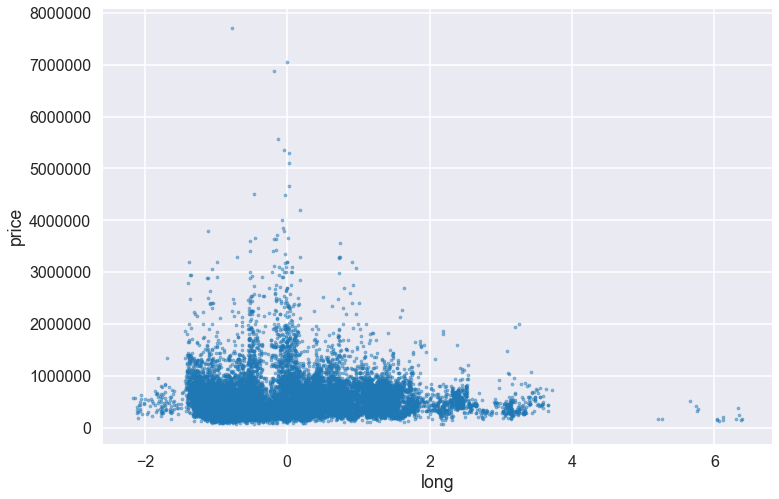

corr between price and sqft_living15 : 0.585019107555


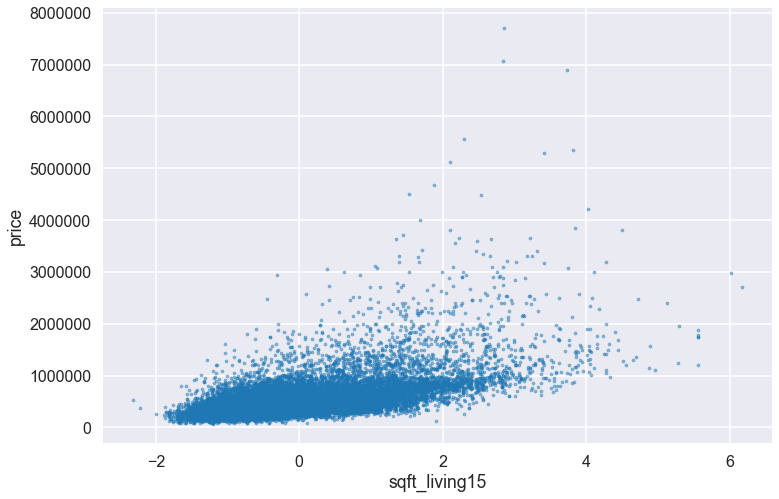

corr between price and sqft_lot15 : 0.0841687342333


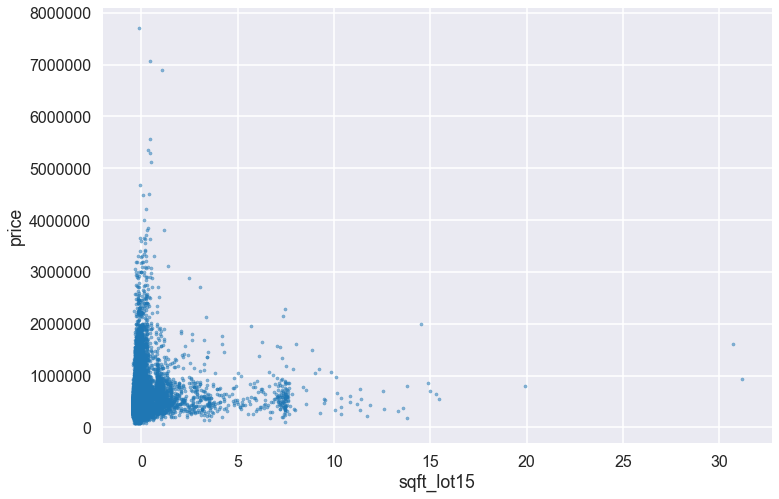

In [4]:
for col in cols:
    fig, ax = plt.subplots(figsize=(12,8))
    df.plot(kind='scatter', x=col, y='price', ax=ax, s=10, alpha=0.5)
    print("corr between price and", col,":",pearsonr(df[col].values, df.price.values)[0])
    plt.show()

# Check for covariance between features

We don't want correlated features in our model, as this makes the features redundant and could reduce the performance of the model.

In [5]:
x_check_cov = df.as_matrix(columns=cols)
x_check_cov.shape

(19451, 17)

In [6]:
Sigma = (1/x_check_cov.shape[0])*np.dot(x_check_cov.T,x_check_cov)
Sigma = abs(Sigma)

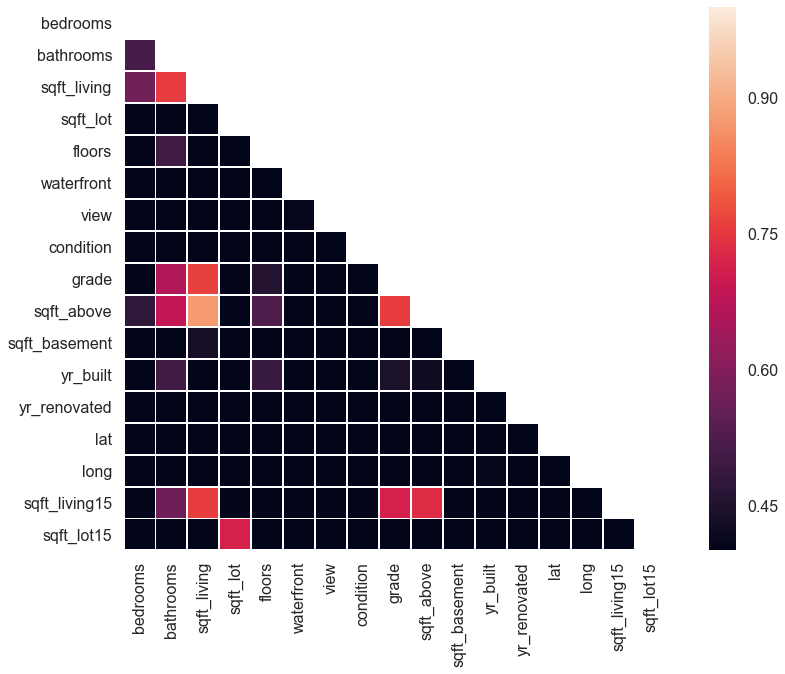

In [7]:
mask = np.zeros_like(Sigma)
mask[np.triu_indices_from(Sigma)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(Sigma, mask=mask, square=True, vmin=0.4, ax=ax, linewidths=1, xticklabels=cols, yticklabels=cols)
    plt.show()

### Some features are correlated

We see features such as sqft_above and sqft_lving are highly correlated (almost 0.8). We will get rid of redundant features.

In [8]:
discard_cols = ['grade','bathrooms','sqft_above','sqft_lot','sqft_lot15']
cols = [i for i in list(df.columns) if i not in discard_cols]
df.drop(labels=discard_cols,axis=1,inplace=True)
df_test.drop(labels=discard_cols,axis=1,inplace=True)
df.head()

,id,price,bedrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15
0,8847400115,590000.0,-0.396214,0.371153,0.012129,-0.088157,-0.305763,-0.629287,-0.659233,1.159102,-0.209117,-1.402712,1.676135,1.742999
1,3423059140,526000.0,0.677599,0.969271,0.937321,-0.088157,-0.305763,-0.629287,-0.659233,0.410855,4.787220,-0.916440,0.483667,0.399965
2,9406520550,307500.0,-0.396214,-0.470564,0.937321,-0.088157,-0.305763,-0.629287,-0.659233,0.784979,-0.209117,-1.417184,1.257352,-0.016083
3,6661200320,163500.0,-1.470026,-1.118707,0.937321,-0.088157,-0.305763,-0.629287,-0.659233,0.853001,-0.209117,-1.271013,1.243156,-1.366417
4,7202331220,635000.0,2.825223,1.958886,0.937321,-0.088157,-0.305763,-0.629287,-0.659233,1.091080,-0.209117,0.876688,1.250254,0.925500


# Regularized Ridge Regression


We'll be implmenting L2 regularized regression form scratch, using mini-batch (stochastic) gradient descent. The cost function of the model is given by

$$J(W) = \frac{1}{2m}\sum_{i=1}^m (XW - y)^2 + \frac{\lambda}{2m}\sum_{i=1}^nW^2$$

where $X$, $W$, $y$, $\lambda$ and $m$ are the data, model weights, targets, regression penalty and number of data points respectively.

To tune the hyperparameters, we will implement cross validation on a validation set.

Finally, at the end we will train a model on a simpler dataset, only including the sqft_area feature and comparing the SSE of the simpler model to the SSE of the more complex model with more features.

In [9]:
class RidgeGD:
    """
    Performs ridge regression on a dataset with L2 regularization
    """
    
    def __init__(self,lambda_=1,alpha=0.01, batchSize=32,n_iter=100,output_every=10):
        self.lambda_        = lambda_ # the penalty / regularization size
        self.alpha          = alpha # the learning rate
        self.batchSize      = batchSize # the size mini batch for gradient descent
        self.n_iter         = n_iter # the numner of iterations in mini batch gradient descent
        self.output_every   = output_every # how often to print error
        
    def cost(self,x,y,w):
        """
        Calculate the cost with current weights
        INPUT: data x, targets y, weights w
        OUTPUT: cost
        """
        # X ~ mxn
        # y ~ mx1
        # W ~ nx1
        m = x.shape[0]
        h = np.dot(x,w) # mxn * nx1 = mx1
        error = h - y
        w[0] = 0 # dont regularize bias
        J = (1/(2*m))*np.sum(error**2) + (self.lambda_/(2*m))*np.sum(w**2)
        return J
     
    def grad(self,x,w,y):
        """
        Calculate the gradient of the cost function
        INPUT: data x, targets y, weights w
        OUTPUT: gradient of cost function
        """
        m = x.shape[0]
        h = np.dot(x,w)
        error = h - y # mx1
        w[0] = 0 # dont regularize bias term
        partial = (1/m)*np.dot(x.T,error) + (self.lambda_/m)*w # nx1
        return partial
    
    def update_weights(self,x,w,y):
        """
        Update the model weights
        INPUT: data x, targets y, current weights w
        OUTPUT: updated weights
        """
        partial = self.grad(x,w,y)
        w = w - self.alpha*partial
        return w
    
    def get_mini_batch(self,x,y,i):
        """
        Get a minibatch of the data
        INPUT: data x, targets y, iteration i
        OUTPUT: subset of the data X,y
        """
        x_mini = x[i*self.batchSize:(i+1)*self.batchSize,:]
        y_mini = y[i*self.batchSize:(i+1)*self.batchSize,:]
        return x_mini,y_mini
    
    def add_bias(self,x):
        """
        Add a column of 1's as the first column in the data x
        INPUT: data x
        OUTPUT: data x with a column of 1's as first column
        """
        x_bias = np.ones((x.shape[0],1))
        x = np.concatenate((x_bias,x),axis=1)
        return x
    
    def init_weights(self,x):
        """
        Initialize the model weights at random
        INPUT: data x
        OUTPUT: random weights
        """
        return (np.random.random((x.shape[1],1))*2 - 1)*1e-2
    
    def fit(self,x,y):
        """
        Fit a model to the data using mini batch gradient descent
        INPUT: data x, targets y
        OUTPUT: model weights w
        """
        if np.all(x[:,0] == np.ones(x.shape[0])):
            pass
        else:
            x = self.add_bias(x)
            
        w = self.init_weights(x)
        n = np.arange(len(x))
        
        """
        Perform mini batch gradient descent
        """
        J = []
        for epoch in range(1, self.n_iter + 1):
            for i in range(0,round(x.shape[0]/self.batchSize)):
                X_mini,Y_mini = self.get_mini_batch(x=x,y=y,i=i)
                J.append(self.cost(x=X_mini,y=Y_mini,w=w))
                w = self.update_weights(x=x,w=w,y=y)

        return w
    
    def predict(self,x,w):
        """
        Predict the target of new input data
        INPUT: data x, learned weights w
        OUTPUT: predicted targets
        """
        x_bias = np.ones((x.shape[0],1))
        x = np.concatenate((x_bias,x),axis=1)
        return np.dot(x,w)

# SSE

Sum of squared error (SSE), is defined as follows

$$\text{SSE} = \sum_{i=1}^{m}(y_i - \hat{y_i})^2$$

where $y_i$ is the true target value, and $\hat{y_i}$ is the predicted target value.

We will use SSE as a metric for the error of a model, and compare SSE values to determine the bets model hyperparameters and best ultimate model.

In [10]:
# The features we will be using to predict price
[col for col in list(df.columns) if col not in ['id','price']]

['bedrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15']

In [74]:
# Create matrices X and Y for training and testing
X = df.as_matrix(columns=[col for col in list(df.columns) if col not in ['id','price']])
Y = df.as_matrix(columns=['price'])
X_test = df_test.as_matrix(columns=[col for col in df_test if col not in ['id','price']])
Y_test = df_test.as_matrix(columns=['price'])

## Cross Validate

We use cross validation to find the best training rate $\alpha$ and penalty $\lambda$

In [75]:
def CrossValidate(x,y,alpha,lambda_):
    """
    Use cross validation on the development data set to obtain the optimal hyperparameters
    INPUT: data x, targets y, alpha (start, end, num), lambda (start, end, num)
    OUTPUT: errs_dict, a dictionary of (alpha,lambda) keys and SSE error values
    """
    
    alphas = np.linspace(alpha[0],alpha[1],alpha[2])
    lambdas_ = np.logspace(lambda_[0],lambda_[1],lambda_[2])
    
    # Use k-fold (10-fold) cross val
    k=10
    cv = KFold(n_splits=k, shuffle=False)
    train_indices = [i[0] for i in cv.split(x)]
    val_indices = [i[1] for i in cv.split(x)]
    
    errs_dict = {(a,l):0 for a,l in zip(alphas,lambdas_)}

    # Loop over alphas and lambdas hyperparams
    for a in alphas:
        print("alpha:",a)
        for lam in lambdas_:
            cv_sse_err = []
            for i in range(k):
                
                x_train = x[train_indices[i],:]
                y_train = y[train_indices[i],:]
                
                x_val = x[val_indices[i],:]
                y_val = y[val_indices[i],:]
                
                model = RidgeGD(lambda_=lam, alpha=a, batchSize=64, n_iter=50, output_every=50)
                W = model.fit(x=x_train,y=y_train)
                
                sse = sum((model.predict(x_val,W) - y_val)**2)[0]
                cv_sse_err.append(sse)
                
            errs_dict[(a,lam)] = (1/k)*sum(cv_sse_err)
    
    return errs_dict

In [159]:
# This takes about 10 minutes to run
errs_dict = CrossValidate(X,Y,(0.5,0.69,5),(1,2,5))

alpha: 0.5
alpha: 0.5475
alpha: 0.595
alpha: 0.6425
alpha: 0.69


In [161]:
# Use the minimum value to train the final model
min(errs_dict, key=errs_dict.get)

(0.64249999999999996, 31.622776601683793)

In [110]:
# Train model with optimim hyperparams above
model = RidgeGD(lambda_=32,alpha=0.64, batchSize=32, n_iter=200, output_every=50)
# Model weights
W = model.fit(x=X,y=Y)

## R-squared

The R-squared value is a metric used to evaluate a linear regression model.

$$R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}$$

where $SS_{\text{res}} = \sum_i ( y_i - f_i)^2$ and $SS_{\text{tot}} = \sum_i ( y_i - \bar{y_i})^2$.

Here, $f_i$ is the model's prediction of the $i$'th observation.

An $R^2$ value of 1 indicates a perfect model. A value of $x<1$ indicates that $x\%$ of the variance of the data is explained by the model.

In [113]:
# Training R^2
f = model.predict(w=W,x=X_test)
sstot = ((Y_test - np.mean(Y_test))**2).sum()
ssres = ((Y_test - f)**2).sum()
r2_train = 1 - (ssres/sstot)
# Test R^2
f = model.predict(w=W,x=X)
sstot = ((Y - np.mean(Y))**2).sum()
ssres = ((Y - f)**2).sum()
r2_test = 1 - (ssres/sstot)
print(" Train R^2:", r2_train, "\n", "Test R^2:", r2_test)

 Train R^2: 0.330028065119 
 Test R^2: 0.387864710707


### Comparison to package - Scikit

We compare our from scratch implemtnation to that of scikit's.

In [116]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=32, solver='saga')
model_sk = clf.fit(X=X, y=Y)
preds = clf.predict(X)
print(" Train R^2:",model_sk.score(X=X,y=Y), "\n", "Test R^2:", model_sk.score(X=X_test,y=Y_test))

 Train R^2: 0.663901701565 
 Test R^2: 0.642658224992


### Plot from scratch model

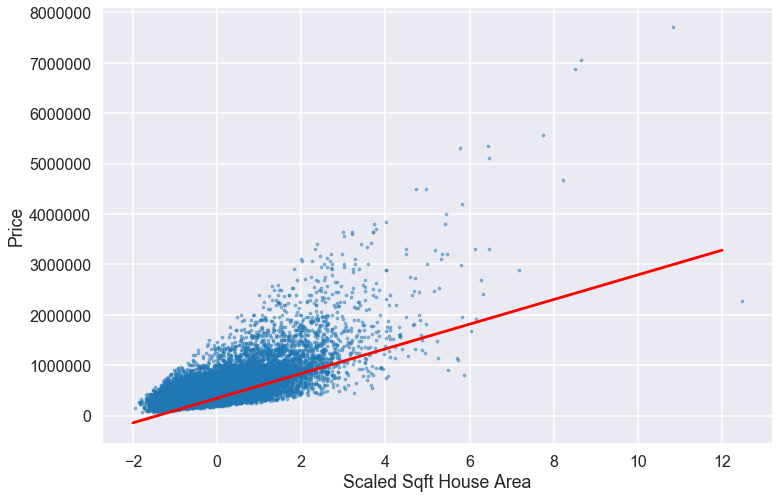

In [25]:
def line(m,b,x):
    """
    Return the points on a line
    INPUT: m (line slope), b (line intersect / bias), x (x values of the line)
    OUTPUT: an array of y values for every corresponding x value
    """
    return m*x+b

# Plot appropriate weights and biases and data to see how well line fits through data
l = line(m=W[2],b=W[0],x=np.linspace(-2,12,1000))
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,1],Y,s=10,alpha=0.5)
ax.plot(np.linspace(-2,12,1000),l,color='r')
ax.set_ylabel("Price")
ax.set_xlabel("Scaled Sqft House Area")
plt.show()

## Conclusions

Our from scratch SGD ridge regression model performs poorly compared to a standard open source package such as scikit; our test $R^2$ is only 0.39 while the scikit model achieved a test score of 0.64. This would indicate that our model could not find the (global) minimum, and became stuck somewhere in the feature / cost space during gradient descent. Perhaps a more sophistaced algorithm may have perforrmed better, such as momentum or Adam.

We will train a model on a simpler dataset, using only the sqft_area feature of the original dataset and calculating the SSE of the model.

# Simpler Model -  sqft_area feature only

In [117]:
# Create simple dataset
# First, cross validate the model to find optimum hyperparms
X_simple = df.as_matrix(columns=['sqft_living'])
# errs_dict = CrossValidate(X_simple,Y,(0.98,1.3,5),(1,2,5))

In [ ]:
# Use these optimum hyperparams in simple model
min(errs_dict, key=errs_dict.get)

In [121]:
Y = df.as_matrix(columns=['price'])
model_simple = RidgeGD(lambda_=100, alpha=1, batchSize=32, n_iter=200, output_every=50)
W_simple = model_simple.fit(x=X_simple,y=Y)

In [122]:
# Make a test data set using only sqft_living
X_test_simple = df_test.as_matrix(columns=['sqft_living'])

In [123]:
f_simple = model_simple.predict(w=W_simple,x=X_simple)
sstot_simple = ((Y - np.mean(Y))**2).sum()
ssres_simple = ((Y - f_simple)**2).sum()
r2_simple_train = 1 - (ssres_simple/sstot_simple)

f_simple = model_simple.predict(w=W_simple,x=X_test_simple)
sstot_simple = ((Y_test - np.mean(Y_test))**2).sum()
ssres_simple = ((Y_test - f_simple)**2).sum()
r2_simple_test = 1 - (ssres_simple/sstot_simple)
print(" Train R^2:", r2_simple_train, "\n", "Test R^2:", r2_simple_test)

 Train R^2: 0.496297153252 
 Test R^2: 0.452892285244


In [126]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=100, solver='saga')
model_sk = clf.fit(X=X_simple, y=Y)
preds = clf.predict(X_test_simple)
print(" Train R^2:",model_sk.score(X=X_simple,y=Y), "\n", "Test R^2:", model_sk.score(X=X_test_simple,y=Y_test))

 Train R^2: 0.49629993066 
 Test R^2: 0.452804000412


### Plot from scratch model

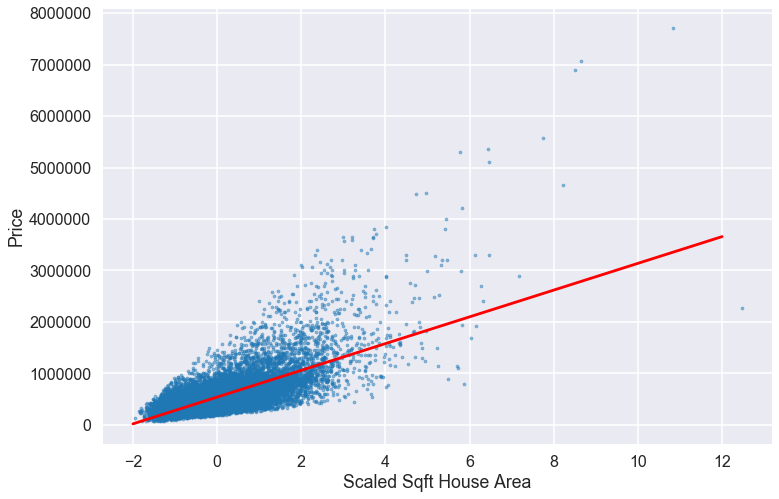

In [127]:
# Plot appropriate weights and biases and data to see how well line fits through data
l = line(m=W_simple[1],b=W_simple[0],x=np.linspace(-2,12,1000))
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(X_simple,Y,s=10,alpha=0.5)
ax.plot(np.linspace(-2,12,1000),l,color='r')
ax.set_ylabel("Price")
ax.set_xlabel("Scaled Sqft House Area")
plt.show()

# Conclusions

Using our from scratch implementation, the simpler model, using only sqft_area, performed better than the complex model using all the features. The simpler model has a test $R^2$ value of 0.45 compared to the complex model with test $R^2$ of 0.38.

However, using the scikit implementation, the test $R^2$ value actually decreased using the simpler dataset, from 0.45. This indicates that there is valuable information in the extra features that allows a more powerful model to be built for predictions.